In [1]:
import numpy as np
import math
import statistics as stat
import random
import pandas as pd

from scipy.optimize import isotonic_regression
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import interp1d

from utils import cross_bin_matching, neighbour_matching, PairSwapICI_test, marg_indep_test
from scipy.stats import norm
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches


lblue = (40/255,103/255,178/255)
sgreen = (46/255,139/255,87/255)
cred = (0.69411765, 0.01568627, 0.05490196)

## Data setup and visualization

In [2]:
data = pd.read_csv('diabetes.csv') # can be downloaded from uci ml repository
data = data.dropna()
print(data.shape)
print(list(data.columns))
data.head()

(768, 9)
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Checking Stoch Monotonicity

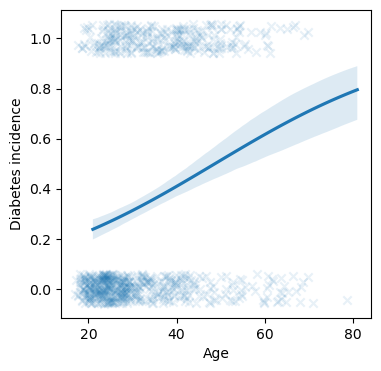

In [3]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize =(4,4))
b = sns.regplot(x=data["Age"],y=data["Outcome"], logistic=True, x_jitter = 4, y_jitter = 0.06,
            marker = 'x', scatter_kws = {'alpha':0.1})
b.set_xlabel("Age", fontsize=10)
b.set_ylabel("Diabetes incidence", fontsize=10)
fig.savefig('figures/relation_with_age.pdf')

### checking relation with other variables

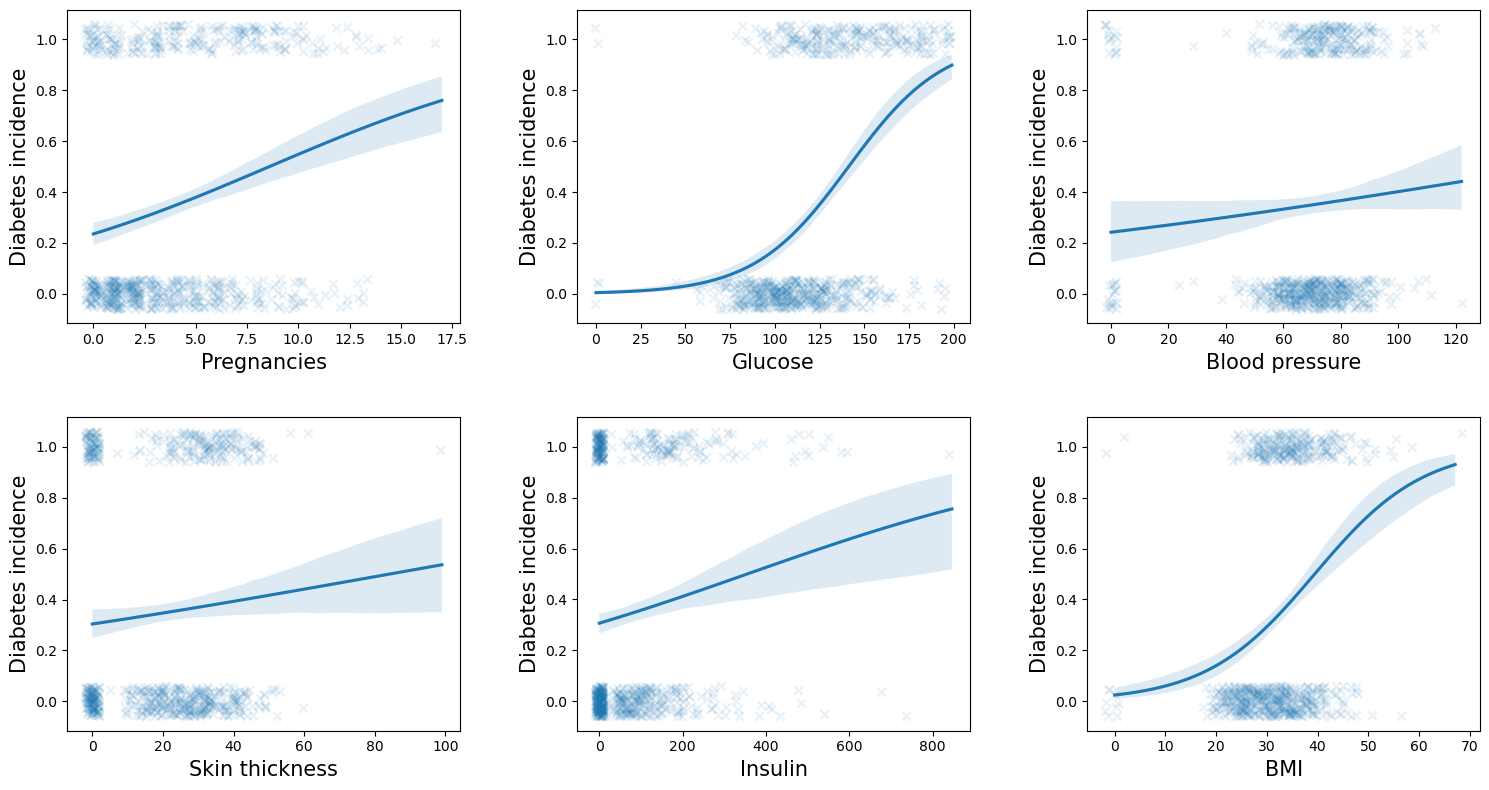

In [4]:
plot_config = [
    {"col": "Pregnancies", "xlabel": "Pregnancies", "x_jitter": 0.4},
    {"col": "Glucose", "xlabel": "Glucose", "x_jitter": 2},
    {"col": "BloodPressure", "xlabel": "Blood pressure", "x_jitter": 2},
    {"col": "SkinThickness", "xlabel": "Skin thickness", "x_jitter": 2},
    {"col": "Insulin", "xlabel": "Insulin", "x_jitter": 10},
    {"col": "BMI", "xlabel": "BMI", "x_jitter": 2},
]
scatter_kws = {'alpha': 0.1}
ylabel = "Diabetes incidence"

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, config in zip(axes.flatten(), plot_config):
    sns.regplot(
        x=data[config["col"]],
        y=data["Outcome"],
        logistic=True,
        x_jitter=config["x_jitter"],
        y_jitter=0.06,
        marker='x',
        scatter_kws=scatter_kws,
        ax=ax
    )
    ax.set_xlabel(config["xlabel"], fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    
fig.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.savefig('figures/diabetes_risk_factors.pdf')

## Run experiments

We consider 6 choices for $Y$: 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' and 'BMI', and then we do the following three tests to study dependence of $X$ (outcome) and $Y$, with $Z$ denoting 'Age':
* marginal independence test with permutation test
* conditional independence test with PairSwap-ICI test
* conditional independence test for synthetic controls with PairSwap-ICI test

In [5]:
def compute_p_values(X, Y, Z, K, mu_hat):
    """Compute p-values for marginal, conditional, and control tests."""
    p_values = {}

    # === compute matchings ==== 
    M_nbhd = neighbour_matching(Y, Z)
    M_cb = cross_bin_matching(Y, Z, K)

    # === Experiment 1: test for marginal independence === 
    p_values["marg"] = marg_indep_test(X, Y)

    # === Experiment 2: test for conditional independence ===
    p_values["cond_nghbr"] = PairSwapICI_test(X, Y, M_nbhd)
    p_values["cond_cbin"] = PairSwapICI_test(X, Y, M_cb)

    # === Experiment 3: test for conditional independence with synthetic controls ===
    X_control = (np.random.rand(len(Z)) <= mu_hat(Z)) * 1
    p_values["ctrl_nghbr"] = PairSwapICI_test(X_control, Y, M_nbhd)
    p_values["ctrl_cbin"] = PairSwapICI_test(X_control, Y, M_cb)

    return p_values

def bootstrap(data, K, nbootstrap):
    """Perform bootstrap analysis."""
    results = {
        "marg": np.zeros((nbootstrap, 6)), # for 6 choice of Y feature
        "cond_nghbr": np.zeros((nbootstrap, 6)),
        "cond_cbin": np.zeros((nbootstrap, 6)),
        "ctrl_nghbr": np.zeros((nbootstrap, 6)),
        "ctrl_cbin": np.zeros((nbootstrap, 6))
    }

    for k in range(nbootstrap):
        
        # === Split data into train and test sets ===
        shuffled_data = data.sample(frac=0.5, replace=False)
        Itr, Ite = np.array_split(np.random.permutation(data.shape[0]), 2)
        train_data = data.iloc[Itr];test_data = data.iloc[Ite]

        # === Find estimate of mu: train isotonic regression model ===
        o = np.argsort(train_data["Age"])
        prob = isotonic_regression(train_data.Outcome[Itr[o]]).x
        mu_hat = interp1d(train_data.Age[Itr[o]], prob, kind='next', assume_sorted=True, fill_value='extrapolate')

        # === Run the three experiments on test split=== 
        Z = np.array(test_data["Age"])
        X = np.array(test_data["Outcome"])

        # === Compute p-values for each feature ===
        for i, column in enumerate(data.columns[:6]):
            Y = np.array(test_data[column])
            p_vals = compute_p_values(X, Y, Z, K, mu_hat)
            
            for key, value in p_vals.items():
                results[key][k, i] = value

    return results

In [6]:
def summarize_results(results, nbootstrap, columns):
    """Summarize bootstrap results as mean and standard error."""
    
    summary_mean = pd.DataFrame({
        "Y": columns[:6],
        "Marg_pvalue": np.mean(results["marg"], axis=0),
        "Cond_pvalue_nghbr": np.mean(results["cond_nghbr"], axis=0),
        "Cond_pvalue_cbin": np.mean(results["cond_cbin"], axis=0),
        "Ctrl_pvalue_nghbr": np.mean(results["ctrl_nghbr"], axis=0),
        "Ctrl_pvalue_cbin": np.mean(results["ctrl_cbin"], axis=0),
    }).round(3)

    summary_se = pd.DataFrame({
        "Y": columns[:6],
        "Marg_pvalue": np.std(results["marg"], axis=0) / np.sqrt(nbootstrap),
        "Cond_pvalue_nghbr": np.std(results["cond_nghbr"], axis=0) / np.sqrt(nbootstrap),
        "Cond_pvalue_cbin": np.std(results["cond_cbin"], axis=0) / np.sqrt(nbootstrap),
        "Ctrl_pvalue_nghbr": np.std(results["ctrl_nghbr"], axis=0) / np.sqrt(nbootstrap),
        "Ctrl_pvalue_cbin": np.std(results["ctrl_cbin"], axis=0) / np.sqrt(nbootstrap),
    }).round(3)

    return summary_mean, summary_se

# Parameters
K = 50 # number of bins used for cross-bin matching
nbootstrap = 3000 # number of bootstrap iterations

# Run analysis
results = bootstrap(data, K, nbootstrap)
result_mean, result_se = summarize_results(results, nbootstrap, data.columns)

In [7]:
print(result_mean)

               Y  Marg_pvalue  Cond_pvalue_nghbr  Cond_pvalue_cbin  \
0    Pregnancies        0.001              0.447             0.426   
1        Glucose        0.001              0.002             0.001   
2  BloodPressure        0.158              0.506             0.501   
3  SkinThickness        0.123              0.244             0.128   
4        Insulin        0.023              0.158             0.225   
5            BMI        0.001              0.034             0.001   

   Ctrl_pvalue_nghbr  Ctrl_pvalue_cbin  
0              0.520             0.550  
1              0.508             0.550  
2              0.500             0.555  
3              0.512             0.566  
4              0.502             0.544  
5              0.503             0.564  


In [8]:
print(result_se)

               Y  Marg_pvalue  Cond_pvalue_nghbr  Cond_pvalue_cbin  \
0    Pregnancies        0.000              0.005             0.004   
1        Glucose        0.000              0.000             0.000   
2  BloodPressure        0.003              0.005             0.004   
3  SkinThickness        0.002              0.004             0.003   
4        Insulin        0.001              0.003             0.004   
5            BMI        0.000              0.001             0.000   

   Ctrl_pvalue_nghbr  Ctrl_pvalue_cbin  
0              0.005             0.005  
1              0.005             0.005  
2              0.005             0.005  
3              0.005             0.005  
4              0.005             0.005  
5              0.005             0.005  
